In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 96% !important; }</style>"))

## Particle Filtering
I wanted to implement some toy codes to understand the following
1. Bootstrap Filter (Uses Importance Sampling)
2. Branching Filter 

It would be much more fruitful if the observations in data are log-returns or stock prices as eventually, I would like to apply these methodologies in these application areas. 

### Bootstrap Filter 


In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import numpy.random as npr
import seaborn as sns
%matplotlib inline

In [3]:
import pandas as pd
prices = pd.read_csv("../data/AA.csv")
stockprices = prices["Adj Close"]
prices["logreturns"] = np.log(stockprices) - np.log(prices["Adj Close"].shift(1))
logreturns = prices["logreturns"]
'''
PS-1
From the parameter set defined in the paper
(Parameters not calibrated)
'''
S_0 = stockprices[0]
V_0 = 0.025
prices = prices[1:]
stockprices = prices["Adj Close"]

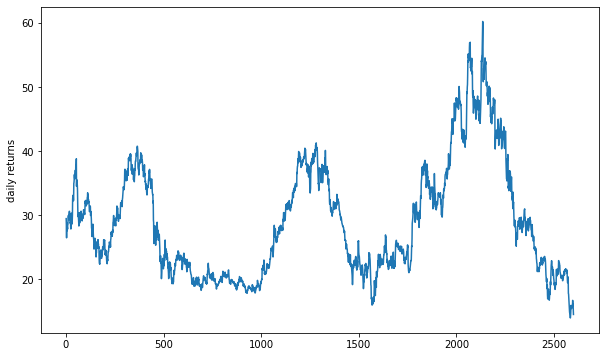

In [4]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=UserWarning)
    stockprices.plot(figsize = (10, 6))
    plt.ylabel("daily returns")

In [5]:
# Heston Model Hyperparameters
params = {
    'mu': -0.04, 
    'nu': 0.01,
    'mean_reversion_coeff': 5.3,
    'rho': -0.7,
    'kappa': -0.5
}

# Stopping time Criterion
epsilon = 1e-5

### Explicit Bootstrap Filter
This works currently 😄

In [20]:
T = 100
delta_t = 1
n = 200
'''
N : Number of Particles
n : Number of grids
'''
# TODO: Alter the code according the varying delta_t
def bootstrap_filter(S_0, V_0, N, params):
    Y = np.zeros((T+1, N))
    W = np.ones(N+1)
    mu, nu, mrc, rho, kappa = params['mu'], params['nu'], params['mean_reversion_coeff'], params['rho'], params['kappa']
    '''Initializing particles'''
    Y[0] = np.sqrt(V_0/N) * np.ones(N)
    W[N] = 1
    # Parameters
    nu_k = max(int(4*nu/kappa**2 + 0.5), 1)
    a, b, c, d, e = np.sqrt(1 - rho**2), mu - nu*rho/kappa, rho*mrc/kappa - 0.5, rho/kappa, (nu - nu_k)/kappa**2 
    f = e*(kappa**2 - nu - nu_k)/2
    V = np.zeros((T+1, N)) # V[0] = V_0
    logS = np.zeros((T+1, N)) # S[0] = S_0
    logL = np.zeros((T+1, N)) #L[0] = 1/N
    logw = np.zeros((T+1, N)) # weights in logarithm, index should start from 1 (Same notation like that of particles)
    V[0] = V_0 * np.ones(N)
    logS[0] = np.log(S_0 * np.ones(N))
    logL[0] = 0
    p = np.ones(N)         
    Y = np.zeros((N, T+1, n))
    
    for i in range(N):
        Y[i][0] = np.sqrt(V_0/n) * np.ones(n)
        for t in range(1, T+1):
            Y[i][t] = np.exp(-mrc/2)*(kappa/2 * np.sqrt(delta_t) * npr.randn(n) + Y[i][t-1])
    for t in range(1, T+1): 
        Vhat = np.sum(Y[:,t]**2, axis=1)
        # Propagation
        logS[t] = logS[t-1] + (a * np.sqrt(V[t-1]*delta_t)*npr.randn(N) + b * (Vhat - V[t-1])*delta_t + d*(Vhat - V[t-1])) # Euler Discretization
        logL[t] = logL[t-1] + (e * (np.log(Vhat/V[t-1]) + mrc)) + (f * (1/Vhat - 1/V[t-1]) * delta_t) # Simple Euler Discretization
        # Normalize
#         for j in range(N):
#             logw[t][j] = np.exp(logL[t][j])/np.sum(np.exp(logL[t]))
        logw[t] = np.log(np.exp(logL[t])/np.sum(np.exp(logL[t])))
        p = np.cumsum(np.exp(logw[t]))
        k = N - 1
        for j in range(N, 0, -1):
            
            u = npr.rand()
            W[j-1] =  (u**(1/j))*W[j]
            while W[j-1] <= p[k-1] and k>=0:
                k = k-1
            logS[t][j-1] = logS[t][k]
            V[t][j-1] = Vhat[k]
            logL[t][j-1] = 0
    return (logS, V, logL)

## Solve this problem tomorrow morning ASAP

In [21]:
%%time
LogS, V, LogL = bootstrap_filter(S_0, V_0, 100, params)

CPU times: user 316 ms, sys: 23.4 ms, total: 339 ms
Wall time: 393 ms


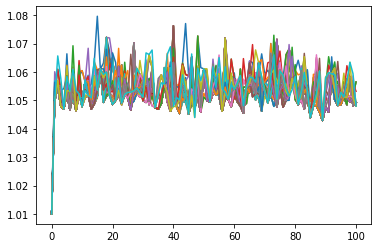

In [22]:
plt.plot(np.exp(V))
plt.show()

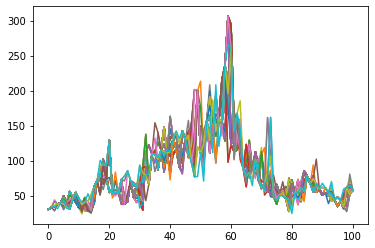

In [23]:
plt.plot(np.exp(LogS))
plt.show()

## Branching Particle Filter

In [25]:
def branching_particle_filter(S_0, V_0, N, T, r):
    '''
    Theorem-1 Computations
    '''
    mu, nu, mrc, rho, kappa = params['mu'], params['nu'], params['mean_reversion_coeff'], params['rho'], params['kappa']
    '''
    num_particles => N_{t-1}
    num_particles_ => N_{t}
    '''
    ''' Parameters '''
    nu_k = max(int(4*nu/kappa**2 + 0.5), 1)
    a, b, c, d, e = np.sqrt(1 - rho**2), mu - nu*rho/kappa, rho*mrc/kappa - 0.5, rho/kappa, (nu - nu_k)/kappa**2 
    f = e*(kappa**2 - nu - nu_k)/2
    '''Declaration of Variables'''
#     V = np.zeros((T+1, N)) 
#     logS = np.zeros((T+1, N)) 
#     logL = np.zeros((T+1, N)) 
#     Vhat = np.zeros((T+1, N)) 
#     logShat = np.zeros((T+1, N)) 
#     logLhat = np.zeros((T+1, N)) 
    
    V_history = [[] for i in range(T+1)]
    logS_history = [[] for i in range(T+1)]
    logL_history = [[] for i in range(T+1)]
    num_particles = N
    '''Initializing Variables'''
    Vhat = V_0 * np.ones(num_particles) # V[0] = V_0
    logShat = np.log(S_0 * np.ones(num_particles)) 
    logLhat = np.zeros(num_particles) #L[0] = 1
    
    A = np.zeros(T+1) # A[0] is dummy
 
    V = V_history[0] = Vhat
    logS = logS_history[0] = logShat
    logL = logL_history[0] = np.zeros(num_particles)
    
    '''Calculate Vhat terms'''
    Y = np.sqrt(V_0/n) * np.ones((num_particles, n))
    for t in range(1, T+1):
        num_particles_ = 0 # Initializing new particle count 
        Y = np.exp(-mrc/2)*((kappa/2) *npr.randn(num_particles, n)*np.sqrt(delta_t) + Y) # Propagate Y_i^j[t] -> Y_i^j[t+1]
        Vhat = np.sum(Y**2, axis=1)
           
#         print("length of V: ", Vhat.shape)
        # Propagation
        logShat = logS + (a * np.sqrt(V*delta_t)*npr.randn(num_particles) + b * (Vhat - V)*delta_t + d*(Vhat - V)) # Euler Discretization
        logLhat = logL + (e * (np.log(Vhat/V) + mrc)) + (f * (1/Vhat - 1/V) * delta_t) # Simple Euler Discretization
        logLhat = np.log(np.exp(logLhat)/np.sum(np.exp(logLhat)))
        A[t] = np.sum(np.exp(logLhat))/N # average weight averaged w.r.t. the "initial # of particles", not num_particles

        logS, V, logL = [], [], [] # Cleaning up the slate to write onto the particle history
        # Select which to branch
        l = 0 
        for j in range(0, num_particles): # Non Branched Particles
            if A[t]/r < np.exp(logLhat[j]) < r*A[t]:
                if (j - l) >= len(logS):
                    logS.append(logShat[j])
                    V.append(Vhat[j])
                    logL.append(logLhat[j]) 
                else:
                    logS[j - l], V[j - l], logL[j - l] = logShat[j], Vhat[j], logLhat[j]
            else: # Branched Particles
                '''
                This part of the algorithm is erroneous in the paper, at least in my opinion. 
                '''
                l = l + 1
                if (l - 1) >= len(logS): # Don't branch this
                    logShat = np.append(logShat, logShat[j])
                    Vhat = np.append(Vhat, Vhat[j])
                    logLhat = np.append(logLhat, logLhat[j])
                else: # Send this for branching
                    logShat[l-1], Vhat[l-1], logLhat[l-1] = logShat[j], Vhat[j], logLhat[j]
        # Branching part of the algorithm
        num_particles_ = num_particles - l
        W = npr.rand(l)/(l)
        W = np.array([W[i] + i/(l) for i in range(l)]) # Stratified Uniform samples
        U = npr.permutation(W)
        for j in range(0, l):
            N_j = int(np.exp(logLhat[j])/A[t]) + (1 if (U[j] <= np.exp(logLhat[j])/A[t] - int(np.exp(logLhat[j])/A[t])) else 0)
#             print(N_j)
            for k in range(0, N_j):
                logS.append(logShat[j]) 
                V.append(Vhat[j]) 
                logL.append(np.log(A[t]))
            num_particles_ += N_j
#         print("Length of V: ", len(V))
        num_particles = num_particles_
        print("Particles:", num_particles)
        logS_history[t] = logS
        V_history[t] = V
        logL_history[t] = logL
        # Re-setting variables
        V = Vhat = np.array(V)
#         print(V.shape)
        logS = logShat = np.array(logS)
        logL = logLhat = np.array(logL)
        Y = np.sqrt(Vhat/n).reshape(num_particles, 1)*np.ones((num_particles, n))
    return (logS_history, V_history, logL_history)

In [27]:
%%time
V_0 = 0.01
LogS, V, LogL = branching_particle_filter(S_0, V_0, 100, T, r=2)


Particles: 103
Particles: 109
Particles: 99
Particles: 106
Particles: 100
Particles: 113
Particles: 102
Particles: 105
Particles: 100
Particles: 98
Particles: 102
Particles: 100
Particles: 48
Particles: 114
Particles: 104
Particles: 98
Particles: 100
Particles: 157
Particles: 111
Particles: 95
Particles: 108
Particles: 86
Particles: 100
Particles: 103
Particles: 113
Particles: 99
Particles: 99
Particles: 101
Particles: 100
Particles: 103
Particles: 104
Particles: 100
Particles: 102
Particles: 104
Particles: 48
Particles: 109
Particles: 101
Particles: 100
Particles: 108
Particles: 101
Particles: 101
Particles: 76
Particles: 104
Particles: 101
Particles: 101
Particles: 101
Particles: 79
Particles: 64
Particles: 95
Particles: 47
Particles: 102
Particles: 105
Particles: 102
Particles: 44
Particles: 104
Particles: 119
Particles: 100
Particles: 99
Particles: 101
Particles: 103
Particles: 60
Particles: 105
Particles: 100
Particles: 105
Particles: 107
Particles: 64
Particles: 102
Particles: 11

In [64]:
a = np.array(LogS[3] , dtype=float)
a

array([3.9305638 , 3.05363706, 3.7369556 , 3.7369556 , 3.7369556 ,
       3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 ,
       3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 ,
       3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 ,
       3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 ,
       3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 ,
       3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 ,
       3.7369556 , 3.7369556 , 3.7369556 , 3.7369556 , 3.29240111,
       3.29240111, 3.29240111, 3.31636549, 3.63869302, 3.63869302,
       3.63869302, 3.63869302, 3.63869302, 3.63869302, 3.63869302,
       3.63869302, 3.63869302, 3.9305638 , 3.95663302, 3.05363706,
       3.42271478, 3.09434859, 3.09434859, 3.09434859, 3.09434859,
       3.09434859, 3.09434859, 3.09434859, 3.09434859, 3.09434859,
       3.09434859, 3.09434859, 3.09434859, 3.09434859, 3.09434859,
       3.09434859, 3.09434859, 3.09434859, 3.09434859, 3.09434

## Weighted Heston Simulation
This also works 😅😁

In [16]:
def weighted_heston(S_0, V_0, n, N, M, T, params = params, epsilon=1e-3):
    '''
    Theorem 1 computations
    '''
    mu, nu, mrc, rho, kappa = params['mu'], params['nu'], params['mean_reversion_coeff'], params['rho'], params['kappa']
    nu_k = max(int(4*nu/kappa**2 + 0.5), 1)
    a, b, c, d, e = np.sqrt(1 - rho**2), mu - nu*rho/kappa, rho*mrc/kappa - 0.5, rho/kappa, (nu - nu_k)/kappa**2 
    sigma = kappa * np.sqrt((1 - np.exp(-mrc/M))/(4*mrc))
    alpha = np.exp(-mrc/(2*M))
    logS = np.zeros((T + 1, N))
    logL = np.zeros((T + 1, N))
    stoppingtimes = np.zeros(N)
    Y = np.zeros((M*T + 1, N, n))
    V = np.zeros((M*T + 1 , N)) #V_0 is dummy
    '''Initialization'''
    logS[0, :] = np.log(S_0 * np.ones(N))
    logL[0, :] = 0 
    stoppingtimes = T * np.ones(N)
    Y[0, :, :] = ((V_0/n)**0.5) * np.ones((N, n))
    
    for t in range(1, T+1):
        '''
        for i in range(N):
            V[t*M, i] = 0
        # This has been already initialized
        '''
        for k in range(M-1, -1, -1):
            Z = npr.randn(N, n)
            Y[t*M - k, :, :] = alpha * Y[t*M - (k+1), :, :] + sigma*Z
            V[t*M - k, :] = V[t*M - k, :] + np.sum(Y[t*M - k, :, :]**2, axis=1)
        
        IntV = (np.sum(V[(t-1)*M:t*M+1, :], axis=0) + np.sum(V[(t-1)*M+1:t*M, :], axis=0) + 2*(V[(t-1)*M+1, :] + V[t*M - 1, :]))/(3*M)
        Nsample = a*np.sqrt(IntV)*npr.randn(N)
        logS[t, :] = logS[t-1, :] + Nsample + b + c*IntV + d*(V[t*M,:] - V[(t-1)*M, :])
        '''Iterating over particles'''
        for j in range(0, N):
            if t <= stoppingtimes[j]:
                if np.min(V[(t-1)*M:t*M, j]) > epsilon:
                    IntVinv[j] = (np.sum(1/V[(t-1)*M:t*M+1, j]) + np.sum(1/V[(t-1)*M+1:t*M, j]) + 2*(1/V[(t-1)*M+1, j] + 1/V[t*M - 1, j]))/(3*M)
                    logL[t, j] = logL[t-1, j] + e*(np.log(V[t, j]/V[t-1, j]) + mrc) + f*IntVinv[j]
                else:
                    stoppingtimes[j] = t - 1
    return (logS, V, logL)

In [17]:
%%time
# Heston Model Hyperparameters
params = {
    'mu': -7, 
    'nu': 0.01,
    'mean_reversion_coeff': 5.3,
    'rho': -0.7,
    'kappa': -0.5
}

# Stopping time Criterion
epsilon = 1e-5

LogS, V, logL = weighted_heston(S_0, V_0, n = 100, N = 200, M = 6, T = 100, params = params)
print(LogS)
print(LogL)

[[ 3.41623058  3.41623058  3.41623058 ...  3.41623058  3.41623058
   3.41623058]
 [ 3.0001517   4.3006274   4.7689174  ...  3.96138069  4.22634814
   4.11567385]
 [ 3.68862405  5.32818066  4.81345064 ...  3.51604667  3.89540574
   5.15520056]
 ...
 [33.72959357 19.73009453 25.66908729 ... -0.26988331 35.87506247
  24.88437202]
 [35.16649547 20.60017075 27.05376446 ...  0.72172128 34.38375851
  24.43679071]
 [36.36564399 18.31457609 26.16019701 ...  1.94268906 34.82718707
  23.60790144]]
[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), [-4.694485332080602, -4.931823954192935, -4.918922977108251, -5

In [ ]:
LogS, V, logL = branching_particle_filter(S_0, V_0, 100, 100, 1.1)